<a href="https://colab.research.google.com/github/Shivp55/DAML/blob/main/ML_Notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive



# **Loading the Dataset**

In [3]:


# File Path
data_path = '/content/drive/MyDrive/ML/Dataset 2/airview_dublincity_roaddata_ugm3.csv'

# Load Dataset
road_data = pd.read_csv(data_path)

In [4]:
# Initial Data Overview
road_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24694 entries, 0 to 24693
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   road_id       24694 non-null  int64  
 1   the_geom      24694 non-null  object 
 2   osm_id        24694 non-null  int64  
 3   osm_code      24694 non-null  int64  
 4   osm_fclass    24694 non-null  object 
 5   osm_name      20209 non-null  object 
 6   osm_ref       6415 non-null   object 
 7   osm_oneway    24694 non-null  object 
 8   osm_maxspeed  24694 non-null  int64  
 9   osm_layer     24694 non-null  int64  
 10  osm_bridge    24694 non-null  bool   
 11  osm_tunnel    24694 non-null  bool   
 12  NO2points     24694 non-null  int64  
 13  NO2drives     24495 non-null  float64
 14  NO2_ugm3      24495 non-null  float64
 15  NOpoints      24694 non-null  int64  
 16  NOdrives      24610 non-null  float64
 17  NO_ugm3       24610 non-null  float64
 18  CO2points     24694 non-nu

In [5]:
road_data.head()

,road_id,the_geom,osm_id,osm_code,osm_fclass,osm_name,osm_ref,osm_oneway,osm_maxspeed,osm_layer,...,CO2_mgm3,COpoints,COdrives,CO_mgm3,O3points,O3drives,O3_ugm3,PM25points,PM25drives,PM25_ugm3
0,3633278,"LINESTRING(-6.156470225 53.394400525, -6.15665...",497788125,5141,service,NaN,NaN,B,30,0,...,NaN,0,NaN,NaN,0,NaN,NaN,2,1.0,3.030
1,3639035,"LINESTRING(-6.3266322 53.3421535, -6.3266241 5...",500417276,5141,service,NaN,NaN,B,0,0,...,793.601,0,NaN,NaN,0,NaN,NaN,1,1.0,5.042
2,2099409,"LINESTRING(-6.1891464 53.3795598, -6.1895315 5...",236680313,5141,service,NaN,NaN,B,0,0,...,791.418,0,NaN,NaN,0,NaN,NaN,1,1.0,32.500
3,3636088,"LINESTRING(-6.2796231 53.3262885, -6.2796544 5...",498987932,5141,service,NaN,NaN,B,0,0,...,836.065,0,NaN,NaN,0,NaN,NaN,1,1.0,6.882
4,3962473,"LINESTRING(-6.264441 53.3131986, -6.2644378 53...",684445633,5141,service,NaN,NaN,B,0,0,...,NaN,0,NaN,NaN,1,1.0,54.447,1,1.0,7.111


In [6]:

# Check for missing values
print("Missing Values per Column:")
print(road_data.isnull().sum())

Missing Values per Column:
road_id             0
the_geom            0
osm_id              0
osm_code            0
osm_fclass          0
osm_name         4485
osm_ref         18279
osm_oneway          0
osm_maxspeed        0
osm_layer           0
osm_bridge          0
osm_tunnel          0
NO2points           0
NO2drives         199
NO2_ugm3          199
NOpoints            0
NOdrives           84
NO_ugm3            84
CO2points           0
CO2drives         205
CO2_mgm3          205
COpoints            0
COdrives           46
CO_mgm3            46
O3points            0
O3drives         1248
O3_ugm3          1248
PM25points          0
PM25drives         18
PM25_ugm3          18
dtype: int64


# **Data Preprocessing**

In [7]:
# 1. Dropping unnecessary columns because these columns are dropped as they do not provide significant information for modeling.
road_data.drop(
    ['road_id', 'the_geom', 'osm_code', 'osm_id', 'osm_name', 'osm_ref'], axis=1, inplace=True)

In [8]:
# 2. Converting 'osm_layer' to string, Converting to string ensures proper handling of categorical data.
road_data['osm_layer'] = road_data['osm_layer'].astype(str)


In [9]:
# 3. Handling missing values
# Impute numeric columns with median and categorical columns with the mode
numeric_cols = road_data.select_dtypes(include=['number']).columns
categorical_cols = road_data.select_dtypes(include=['object']).columns

In [10]:
# Median is used as it is robust to outliers.
imputer = SimpleImputer(strategy='median')
road_data[numeric_cols] = imputer.fit_transform(road_data[numeric_cols])


In [11]:
# Most frequent value is used to fill missing values in categorical columns.
categorical_imputer = SimpleImputer(strategy='most_frequent')
road_data[categorical_cols] = categorical_imputer.fit_transform(road_data[categorical_cols])

In [12]:
# 4. Removing outliers in numeric columns
# Outlier detection using the IQR method. This step removes extreme values that could skew the results.
for col in numeric_cols:
    Q1 = road_data[col].quantile(0.25)
    Q3 = road_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    road_data = road_data[(road_data[col] >= lower_bound) & (road_data[col] <= upper_bound)]


In [13]:
# 5. Filtering pollutant values >= 10. Filtering ensures meaningful pollutant measurements for analysis.
filtered_data = road_data[
    (road_data['NO2points'] >= 10) &
    (road_data['NOpoints'] >= 10) &
    (road_data['CO2points'] >= 10) &
    (road_data['COpoints'] >= 10) &
    (road_data['O3points'] >= 10) &
    (road_data['PM25points'] >= 10)]


In [14]:
# 6. Dropping columns related to points and drives since these columns are redundant for our analysis and can be removed.
cleaned_data = filtered_data.drop(
    [
        'NO2points', 'NO2drives', 'NOpoints', 'NOdrives', 'CO2points', 'CO2drives',
        'COpoints', 'COdrives', 'O3points', 'O3drives', 'PM25points', 'PM25drives'],
    axis=1)

# **Data Overview Post-Preprocessing**

In [15]:
print(cleaned_data.info())
print("Summary Statistics:")
print(cleaned_data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 11843 entries, 144 to 22686
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   osm_fclass    11843 non-null  object 
 1   osm_oneway    11843 non-null  object 
 2   osm_maxspeed  11843 non-null  float64
 3   osm_layer     11843 non-null  object 
 4   osm_bridge    11843 non-null  bool   
 5   osm_tunnel    11843 non-null  bool   
 6   NO2_ugm3      11843 non-null  float64
 7   NO_ugm3       11843 non-null  float64
 8   CO2_mgm3      11843 non-null  float64
 9   CO_mgm3       11843 non-null  float64
 10  O3_ugm3       11843 non-null  float64
 11  PM25_ugm3     11843 non-null  float64
dtypes: bool(2), float64(7), object(3)
memory usage: 1.0+ MB
None
Summary Statistics:
       osm_maxspeed      NO2_ugm3       NO_ugm3      CO2_mgm3       CO_mgm3  \
count  11843.000000  11843.000000  11843.000000  11843.000000  11843.000000   
mean      39.673731      5.514998     -3.430249 

# **Performing Exploratory Data Analysis**

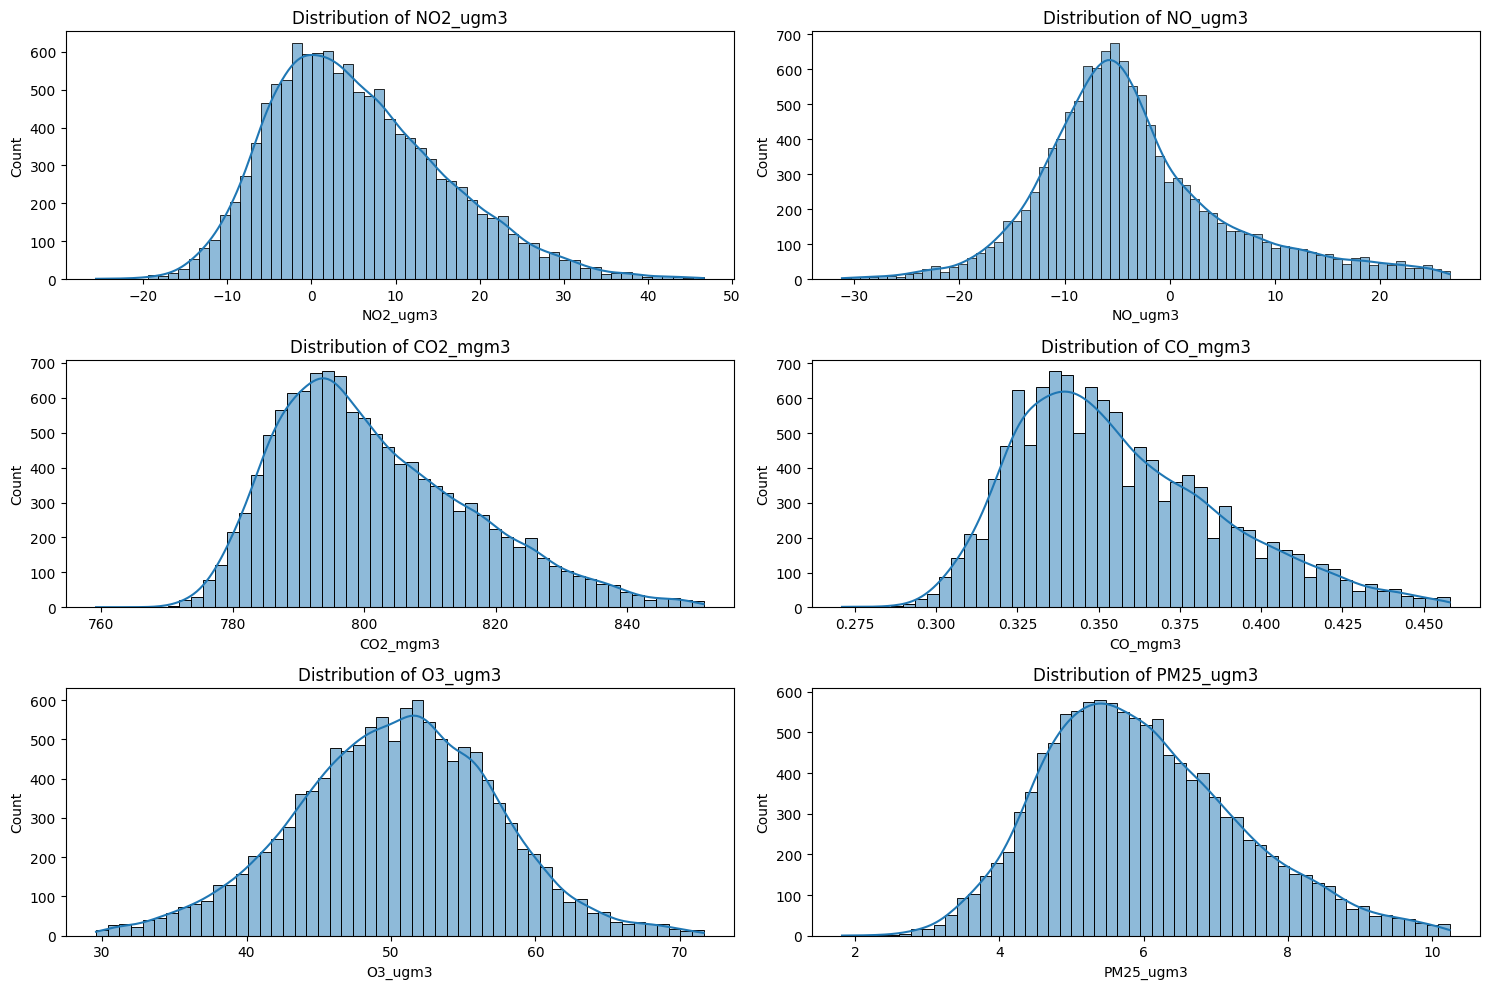

In [20]:
# Function: Distribution Plots for Pollutants
pollutant_features=['NO2_ugm3', 'NO_ugm3', 'CO2_mgm3', 'CO_mgm3', 'O3_ugm3', 'PM25_ugm3']
def plot_pollutant_distributions(data, columns):
    plt.figure(figsize=(15, 10))
    for idx, col in enumerate(columns, 1):
        plt.subplot(3, 2, idx)
        sns.histplot(data[col], kde=True)
        plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

plot_pollutant_distributions(cleaned_data, pollutant_features)

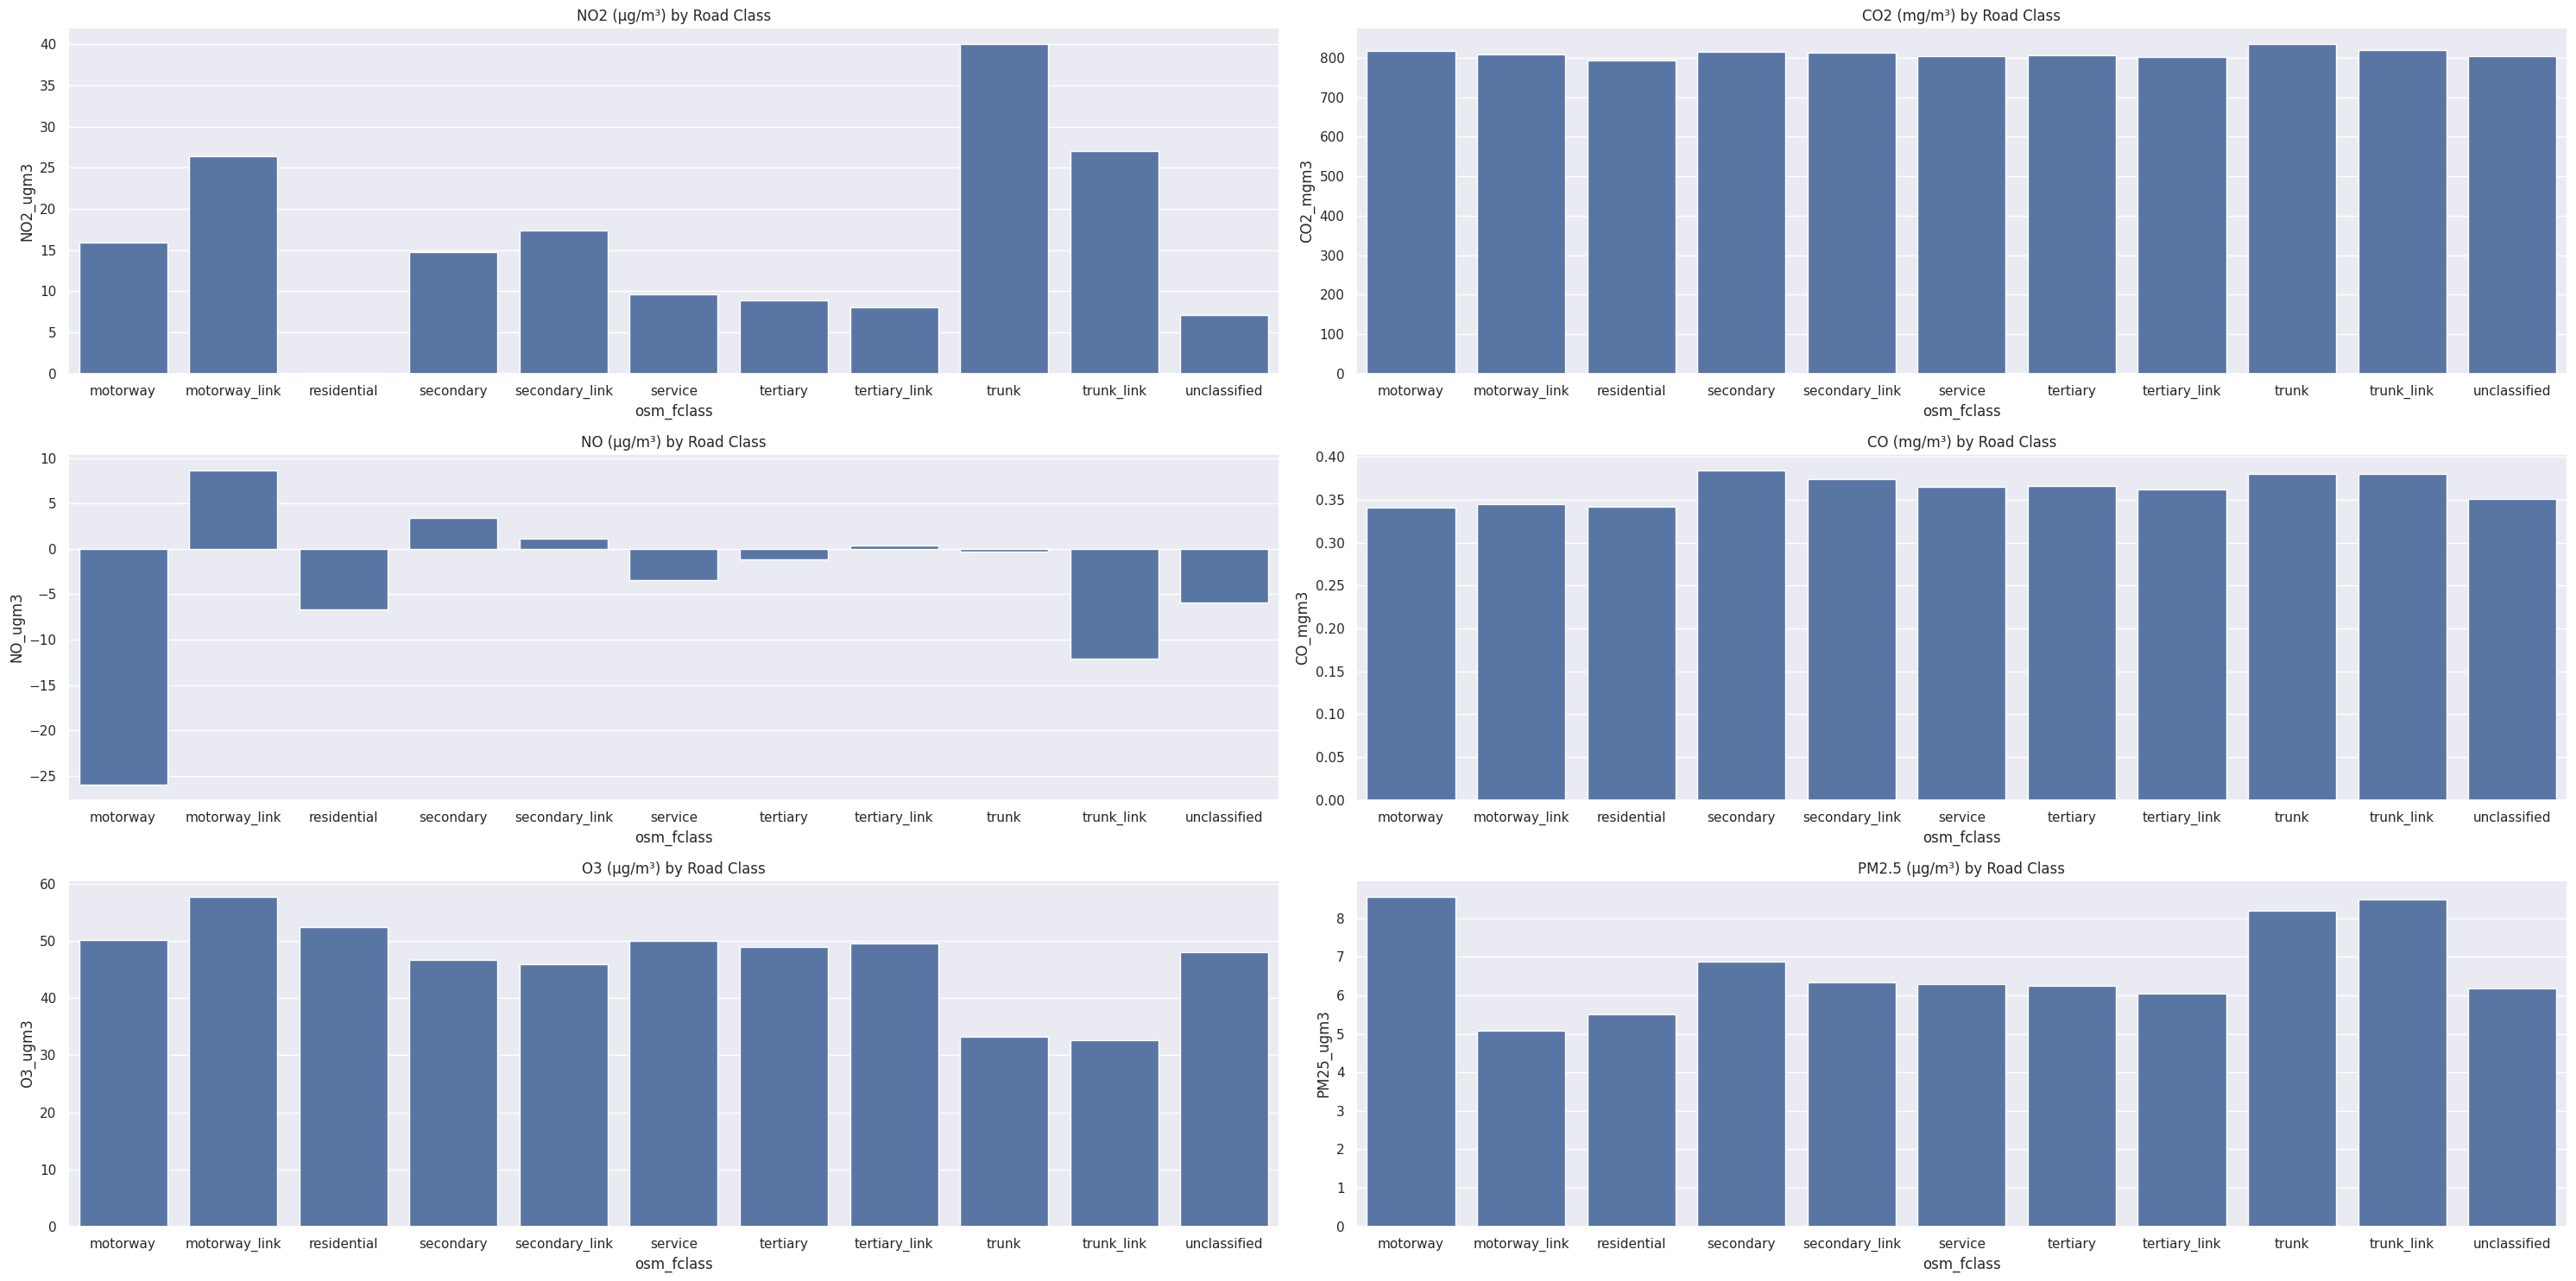

In [21]:
# Grouping street classifications to find patterns within pollutants
# Selecting only numeric columns for aggregation
numeric_cols = ['NO2_ugm3', 'NO_ugm3', 'CO2_mgm3', 'CO_mgm3', 'O3_ugm3', 'PM25_ugm3']
street_class = cleaned_data.groupby('osm_fclass')[numeric_cols].mean().reset_index()

# Plotting pollutant values by road classifications
sns.set(rc={'figure.figsize': (30, 15)})  # Set figure size
fig, axes = plt.subplots(3, 2)  # Create a 3x2 subplot grid

# Plot bar charts for each pollutant
sns.barplot(data=street_class, x='osm_fclass', y='NO2_ugm3', ax=axes[0, 0])
sns.barplot(data=street_class, x='osm_fclass', y='NO_ugm3', ax=axes[1, 0])
sns.barplot(data=street_class, x='osm_fclass', y='CO2_mgm3', ax=axes[0, 1])
sns.barplot(data=street_class, x='osm_fclass', y='CO_mgm3', ax=axes[1, 1])
sns.barplot(data=street_class, x='osm_fclass', y='O3_ugm3', ax=axes[2, 0])
sns.barplot(data=street_class, x='osm_fclass', y='PM25_ugm3', ax=axes[2, 1])

# Add titles to subplots
axes[0, 0].set_title('NO2 (µg/m³) by Road Class')
axes[1, 0].set_title('NO (µg/m³) by Road Class')
axes[0, 1].set_title('CO2 (mg/m³) by Road Class')
axes[1, 1].set_title('CO (mg/m³) by Road Class')
axes[2, 0].set_title('O3 (µg/m³) by Road Class')
axes[2, 1].set_title('PM2.5 (µg/m³) by Road Class')

# Adjust layout for clarity
plt.tight_layout()
plt.show()


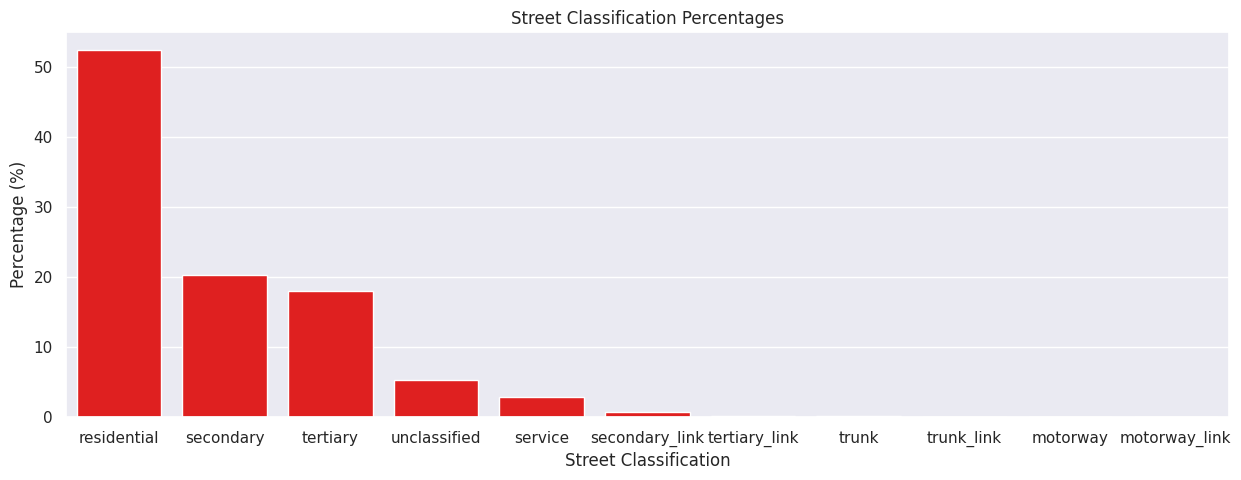

In [22]:
# Function: Bar Plot of Street Classifications
def plot_street_classification(data):
    classification_counts = data['osm_fclass'].value_counts(normalize=True) * 100
    plt.figure(figsize=(15, 5))
    sns.barplot(x=classification_counts.index, y=classification_counts.values, color="red")
    plt.title("Street Classification Percentages")
    plt.ylabel("Percentage (%)")
    plt.xlabel("Street Classification")
    plt.show()

plot_street_classification(cleaned_data)

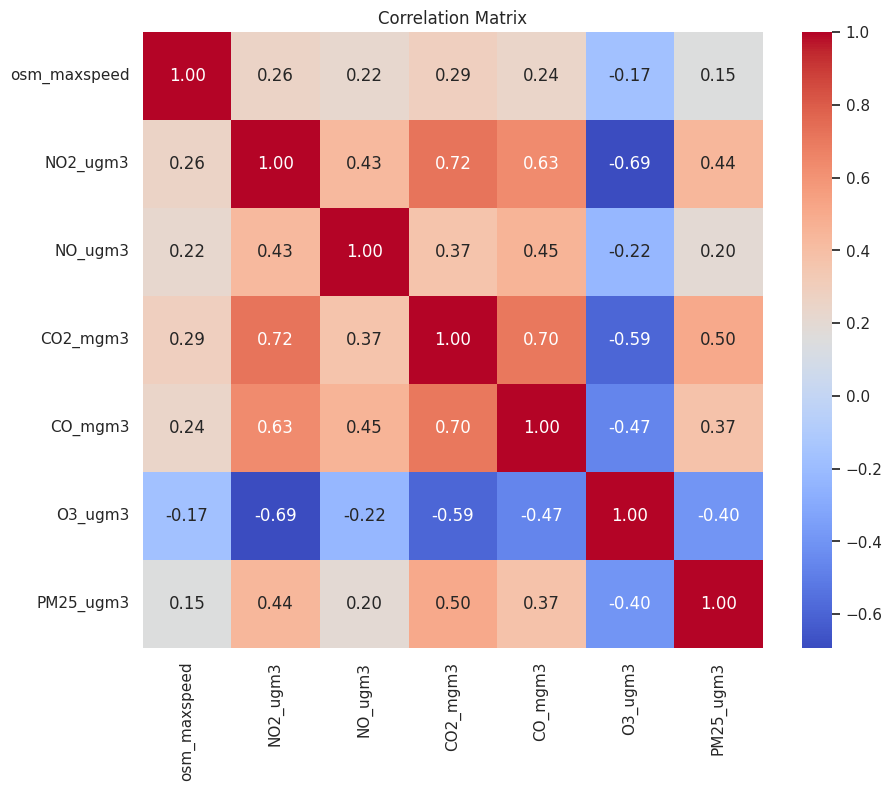

In [23]:
# Function: Correlation Heatmap
def plot_correlation_heatmap(data):
    numeric_data = data.select_dtypes(include=['number'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix")
    plt.show()

plot_correlation_heatmap(cleaned_data)

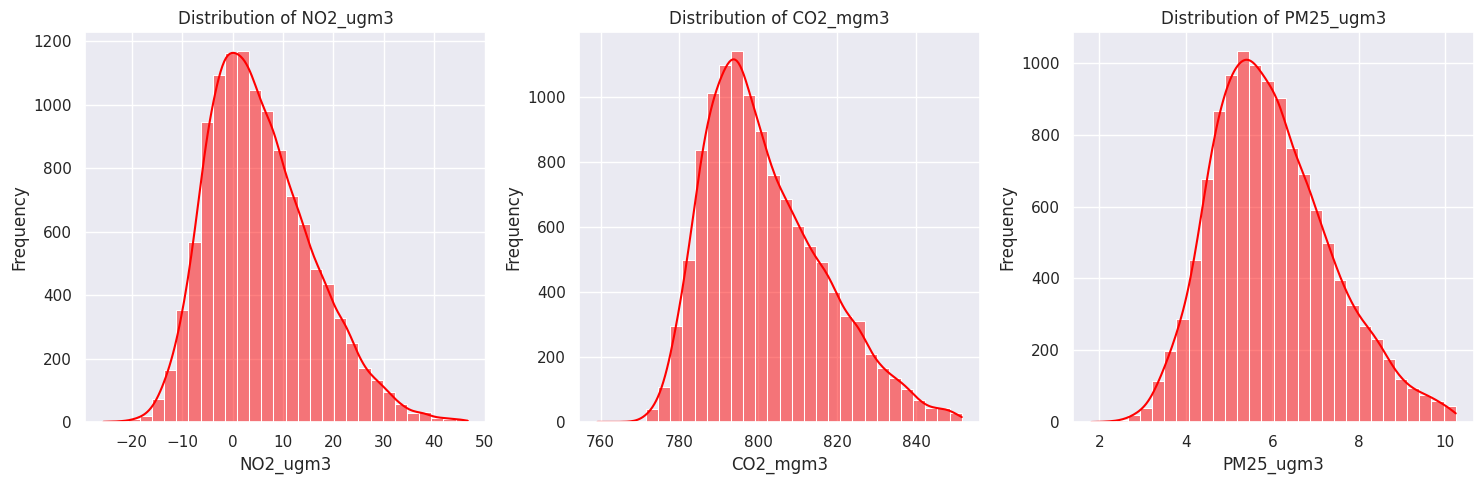

In [24]:
# Distribution of Key Pollutants
def plot_pollutant_distributions(df):
    pollutants = ['NO2_ugm3', 'CO2_mgm3', 'PM25_ugm3']
    plt.figure(figsize=(15, 5))
    for i, pollutant in enumerate(pollutants, 1):
        plt.subplot(1, 3, i)
        sns.histplot(df[pollutant], kde=True, bins=30, color='red')
        plt.title(f'Distribution of {pollutant}')
        plt.xlabel(pollutant)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
plot_pollutant_distributions(cleaned_data)

#**Splitting the Dataset into Train and Test Data**

In [51]:
# Splitting the dataset
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)
print("X_train_reg:", len(X_train_reg))
print("X_test_reg:", len(X_test_reg))
print("y_train_reg:", len(y_train_reg))
print("y_test_reg:", len(y_test_reg))

X_train_reg: 8290
X_test_reg: 3553
y_train_reg: 8290
y_test_reg: 3553


# **Regression**

In [77]:
# Regression Model
reg_features = ['CO2_mgm3', 'PM25_ugm3', 'osm_maxspeed']
X_reg = cleaned_data[reg_features]
y_reg = cleaned_data['NO2_ugm3']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

reg_model = RandomForestRegressor(n_estimators=100, random_state=42)
reg_model.fit(X_train_reg, y_train_reg)

RandomForestRegressor(random_state=42)

In [78]:
y_pred_reg = reg_model.predict(X_test_reg)

In [79]:
# Regression Metrics
print("Regression Metrics")
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg))
print("R2:", r2_score(y_test_reg, y_pred_reg))

Regression Metrics
MAE: 5.916622001125809
MSE: 56.56316407138522
R2: 0.46365472777013195


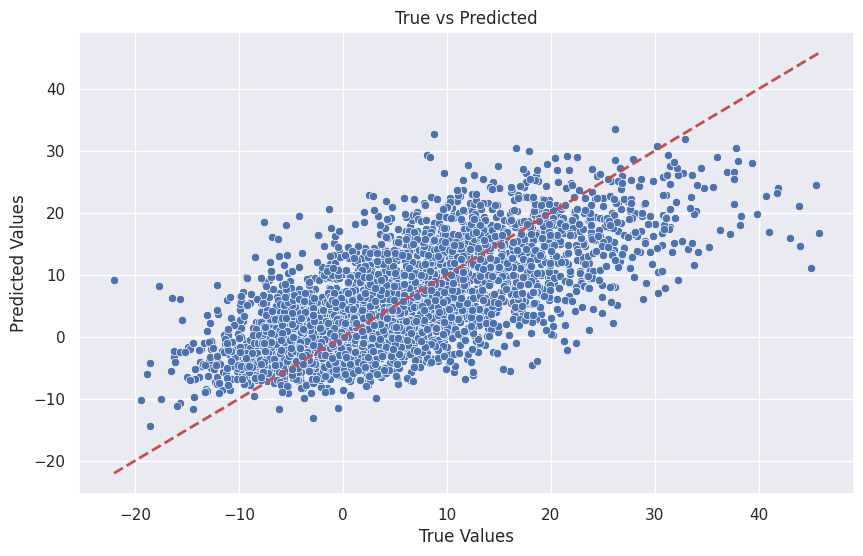

In [80]:
# Function: Plot True vs Predicted and Residuals
def plot_regression_results(y_test, y_pred):
    # True vs Predicted
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
    plt.title("True vs Predicted")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.grid(True)
    plt.show()

# Plot Regression Results
plot_regression_results(y_test_reg, y_pred_reg)

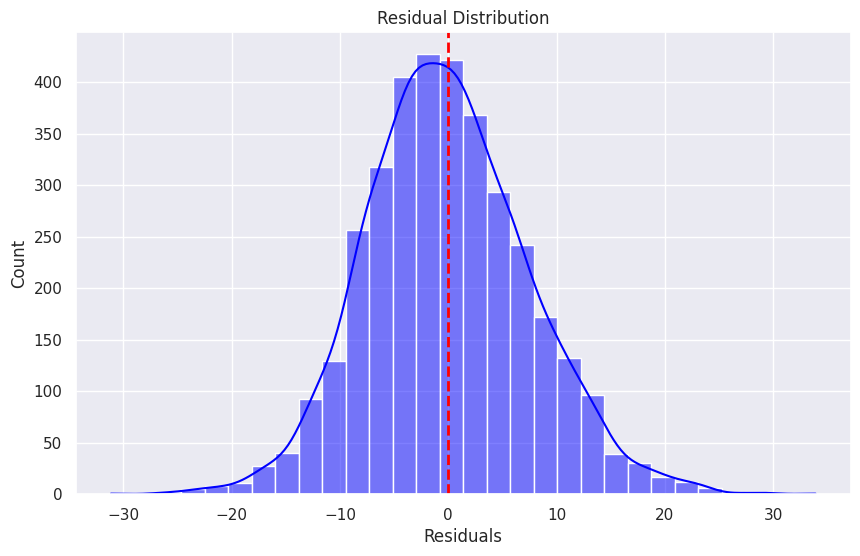

In [81]:
# Plot Residual Distribution
residuals = y_test_reg - y_pred_reg
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')  # Histogram with KDE
plt.title("Residual Distribution")  # Title of the plot
plt.xlabel("Residuals")  # X-axis label
plt.axvline(0, color='red', linestyle='--', linewidth=2)  # Vertical line at 0
plt.grid(True)  # Add grid lines
plt.show()

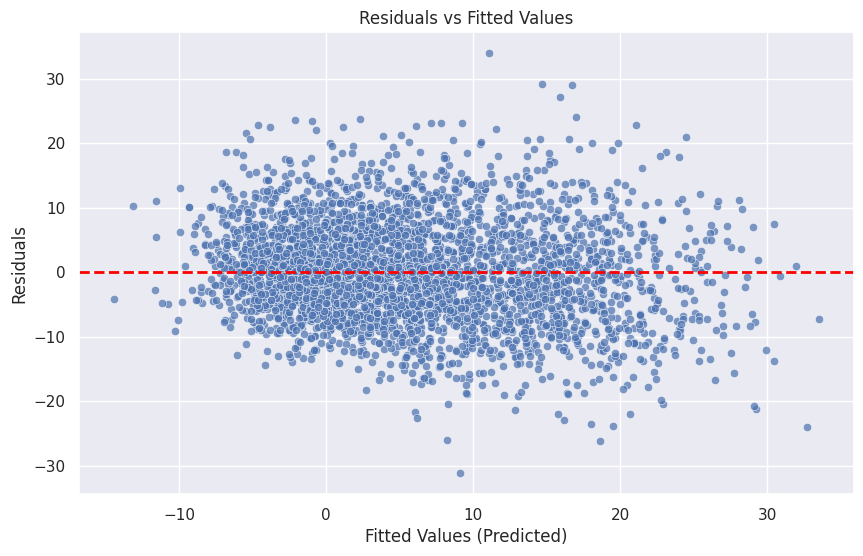

In [82]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_reg, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values (Predicted)")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

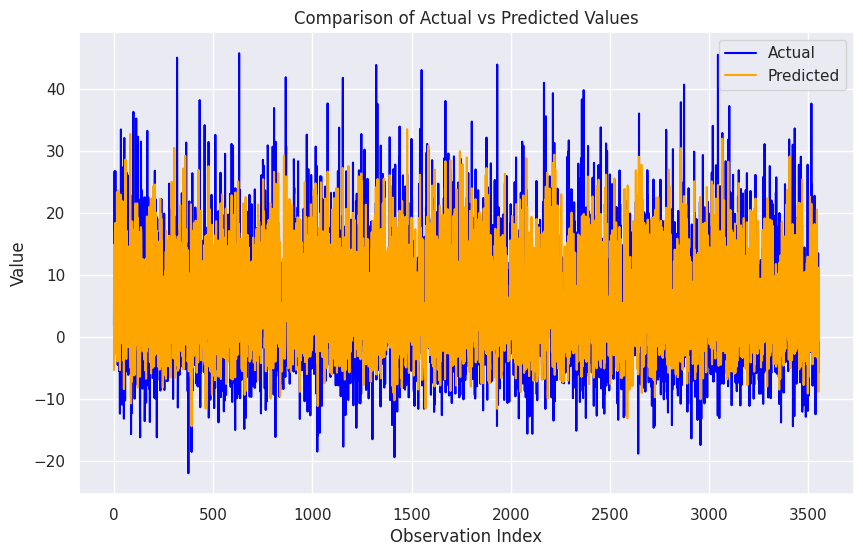

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test_reg)), y_test_reg, label='Actual', color='blue')
plt.plot(np.arange(len(y_pred_reg)), y_pred_reg, label='Predicted', color='orange')
plt.title("Comparison of Actual vs Predicted Values")
plt.xlabel("Observation Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# **Classification**

In [68]:
# Pollution Threshold and Binary Classification Target
pollution_threshold = cleaned_data['NO2_ugm3'].median()
cleaned_data['Pollution_Level'] = (cleaned_data['NO2_ugm3'] > pollution_threshold).astype(int)

In [69]:
# Classification Model
cls_features = ['CO2_mgm3', 'PM25_ugm3', 'osm_maxspeed']
X_cls = cleaned_data[cls_features]
y_cls = cleaned_data['Pollution_Level']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42)

cls_model = RandomForestClassifier(n_estimators=100, random_state=42)
cls_model.fit(X_train_cls, y_train_cls)

y_pred_cls = cls_model.predict(X_test_cls)

In [70]:
# Classification Metrics
print("Classification Metrics")
print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Classification Report:\n", classification_report(y_test_cls, y_pred_cls))

Classification Metrics
Accuracy: 0.7452856740782438
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75      1779
           1       0.76      0.72      0.74      1774

    accuracy                           0.75      3553
   macro avg       0.75      0.75      0.75      3553
weighted avg       0.75      0.75      0.75      3553



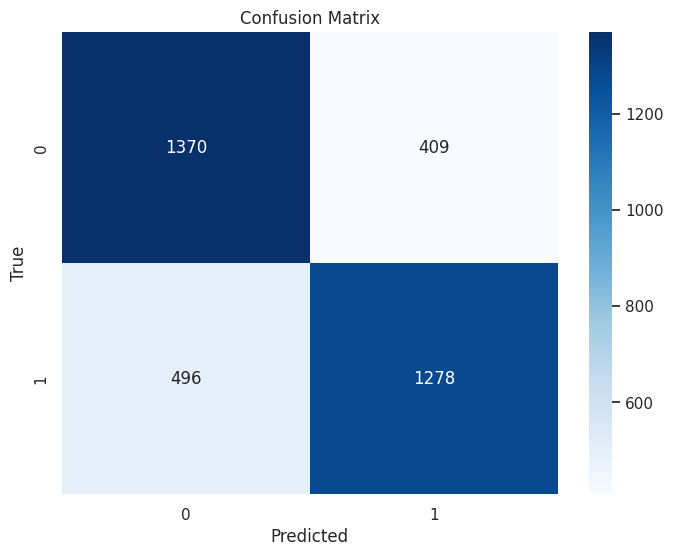

In [71]:
# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_cls, y_pred_cls), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

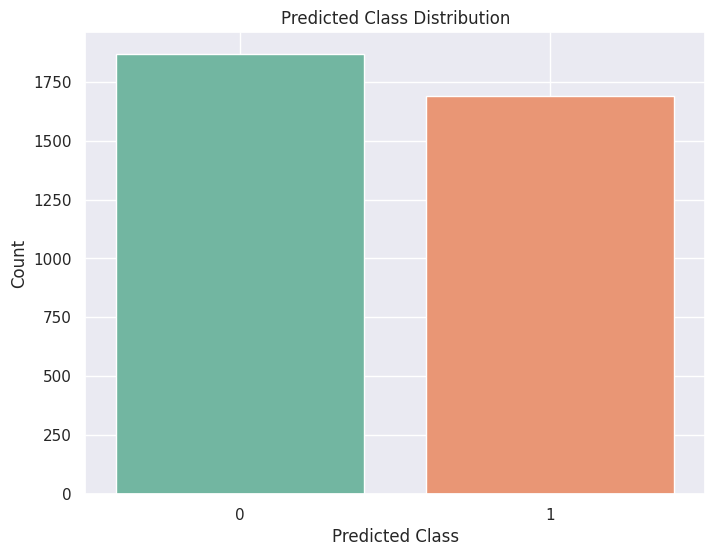

In [72]:
# Predicted Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_pred_cls, hue=y_pred_cls, palette='Set2', dodge=False, legend=False)
plt.title("Predicted Class Distribution")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.grid(True)
plt.show()

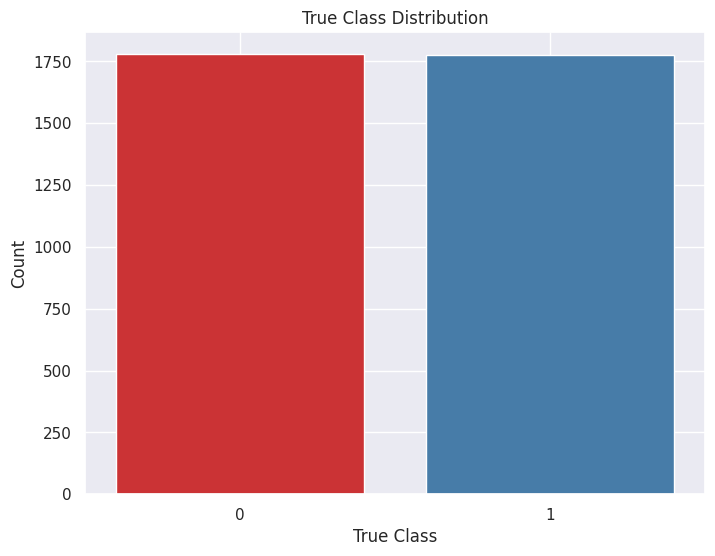

In [73]:
# True Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_test_cls, hue=y_test_cls, palette='Set1', dodge=False, legend=False)
plt.title("True Class Distribution")
plt.xlabel("True Class")
plt.ylabel("Count")
plt.grid(True)
plt.show()

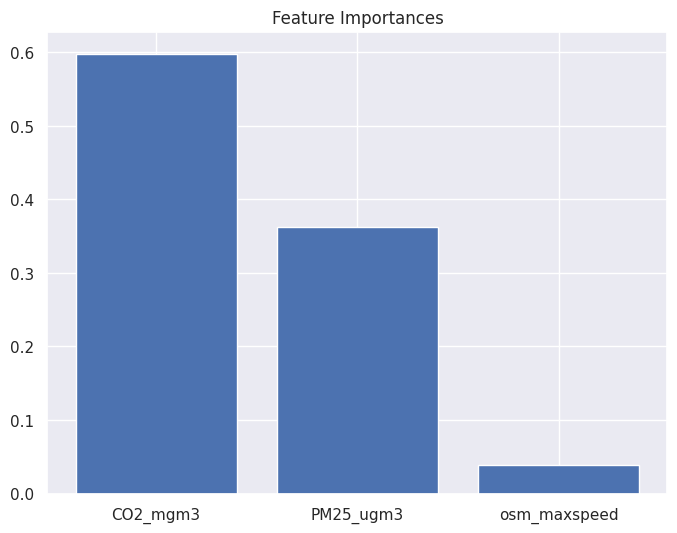

In [76]:
feature_importances = cls_model.feature_importances_
plt.figure(figsize=(8, 6))
plt.bar(cls_features, feature_importances)
plt.title("Feature Importances")
plt.show()
